<a href="https://colab.research.google.com/github/jhermosillo/diplomado_CDD2019/blob/master/04%20Clasificacion_Agrupamiento/3%20Agrupamiento/Notebooks/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center>
    
## **Modelado de texto usando técnicas de reducción de dimensionalidad.**
### Aplicación en WikiPedia para medir semejanza entre documentos.
    
</center></h3>
<h5><center>
    Dr. Jorge Hermosillo Valadez<br>
    Centro de Investigación en Ciencias<br>
    Universidad Autónoma del Estado de Morelos<br>
</center></h5>
</center>
<img src="../img/logoCInC.jpg" width="100"/>
<img src="../img/uaem.jpg" width="100"/>
</center>

Descubrir temas es útil para diversos fines, como agrupar documentos, organizar contenido disponible en línea para recuperar información y hacer recomendaciones. El modelado de temas es una técnica de minería de texto que proporciona métodos para identificar palabras clave concurrentes, con el fin de resumir grandes colecciones de información textual. Ayuda a descubrir temas ocultos en el documento, anotar los documentos con estos temas y organizar una gran cantidad de datos no estructurados. Numerosos proveedores de contenido y agencias de noticias están utilizando modelos de temas para recomendar artículos a los lectores. 

Utilizaremos la técnica de reducción de dimensionalidad PCA (Principal Component Analysis) con el propósito de modelar documentos y establecer semejanzas entre ellos. 

Usaremos el modelo de bolsa de palabras (BoW -- Bag of words), que da como resultado una matriz documento-término que representa documentos en función del conteo de términos. 

En términos generales, el proceso que vamos a seguir es lo siguiente:

![Proceso](../img/BOW.png)

## Para subir carpetas a Colab

In [ ]:
# !apt-get install subversion
# !svn checkout "https://github.com/jhermosillo/diplomado_CDD2019/trunk/04%20Clasificacion_Agrupamiento/3%20Agrupamiento/Data/"

In [1]:
import sys
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import glob

from collections import Counter, OrderedDict

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import wiki_graf as wi

# **Cargado de archivo Wikipedia**

Dato informativo: para este curso primero descargamos los archivos raw de wikipedia (https://www.cs.upc.edu/~nlp/wikicorpus/). Estos archivos son tipo texto.

**Para propósitos de este curso, solo usamos un par de archivos cada uno con varios miles de documentos.**

In [4]:
archivos = glob.glob('Data/textosWiki_1')
print(archivos)

['../Data/textosWiki_1']


Leemos los archivos descargados y sus nombres.

In [5]:
def carga_datos(archivos):
    file=[]
    nombres=[]
    suma = 0
    print("leyendo...")
    for i,filename in enumerate(archivos):
        with open(filename,encoding="ISO-8859-1") as f:
            content = f.read().split()
        #quitamos los espacios en blanco extras
        content = [x.strip().lower() for x in content] 
        size=sys.getsizeof(content)//1048576 #tamaño en MB
        suma += size
        file.append(content)
        nombres.append(filename)
        print(filename)

    print('tamaño del contenido de archivos cargados: \
            {0} MB'.format(suma))
    return file, nombres

In [6]:
file,nombres = carga_datos(archivos)

leyendo...
../Data/textosWiki_1
tamaño del contenido de archivos cargados:             11 MB


Verificamos algunos datos

In [7]:
print(file[0][:20],file[0][-20:])

['<doc', 'id="1871762"', 'title="jud', 'buechler"', 'nonfiltered="1"', 'processed="1"', 'dbindex="435001">', 'judson', 'donald', 'buechler', '(nacido', 'el', '19', 'de', 'junio', 'de', '1968', 'en', 'san', 'diego'] ['sostiene', 'que,', 'para', 'todas', 'las', 'personas,', 'ese', 'criterio', 'imparcial', 'se', 'aplica', 'en', 'forma', 'homogénea.', 'véase', 'también', '.', 'objetividad;', 'endofarticle.', '</doc>']


# **Extracción de documentos**

Ahora vamos a identificar cada documento y elaborar una lista de los mismos.
Para ello, se debe tener en cuenta la forma en que se indexan listas y arreglos en Python.

Como hemos visto, los archivos de Wikipedia traen el identificador de documento ```id=``` (p.ej. _id="1842224"_) y marcadores de inicio y fin de documento, que se reconocen por el caracter ```">"``` (p.ej. _dbindex="430000">_ y ```</doc>```). 

__Lo que vamos a hacer es obtener los indices en donde se encuentran estos datos para extraer el id de documento y su contenido textual__. Esto con el fin de construir una lista de documentos.

Los textos se limpian y procesan usando el módulo ```nltk``` (Natural Language ToolKit) (Loper and Bird, 2002). 

Al final tendremos una lista cuyo contenido será como sigue:

```
docs->[[id_doc1,texto del documento doc1],[id_doc2,texto del documento doc2], ... ]
```

In [8]:
def lee_documentos(file, nombres):
    #palabras demasiado frecuentes
    stop_words = set(stopwords.words('spanish'))

    #conjunto de palabras únicas --vocabulario
    vocabulario = set()

    registros = []
    docs = []
    completo = False
    suma = 0
    for i,archivo in enumerate(file):
        for j,cadena in enumerate(archivo):
            if 'id=' in cadena and completo == False:
                id_ = cadena[4:-1]
            elif 'dbindex=' in cadena and completo == False:
                inicio = j+1
            elif 'doc>' in cadena and completo == False:
                fin = j-1
                completo = True
            if completo:
                x = archivo[inicio:fin]
                r=pd.DataFrame(x,columns=['cadena'])
                r=r.cadena.str.translate(\
                        str.maketrans('','',string.digits))\
                        .str.translate(\
                       str.maketrans('','',string.punctuation))\
                .str.replace('«','')\
                .str.replace('»','').str.replace('(','')\
                .str.replace(')','').str.strip()
                palabras = r.tolist()
                #elimino las stopwords
                texto = [w for w in palabras \
                         if not w in stop_words and len(w)>2]
                #genero el texto del documento
                doc = ' '.join(texto)  
                registros.append([id_,doc,i])
                completo = False
                suma += 1
        print('archivo {0} contiene {1}\
        documentos \n'.format(nombres[i],suma) )
        suma=0
        docs.append(registros)
        registros=[]
    return docs

In [9]:
docs = lee_documentos(file,nombres)
print('Se leyeron {} archivos'.format(len(docs)))
print(docs[0][0][0],docs[0][0][1][:100])

archivo ../Data/textosWiki_1 contiene 4753        documentos 

Se leyeron 1 archivos
1871762 judson donald buechler nacido junio san diego california california unidos jugador profesional ameri


# **Data Frame de documentos**

Ahora vamos a usar pandas (McKinney & others, 2010) para crear un DataFrame que es una estructura de datos especialmente diseñada para manipular grandes cantidades de datos de manera ágil y eficiente.

In [10]:
df = pd.DataFrame(docs[0],columns = ['doc_id','Texto','clase'])
print(len(df.index))
print(df.shape)
df.head()

4753
(4753, 3)


,doc_id,Texto,clase
0,1871762,judson donald buechler nacido junio san diego ...,0
1,1871768,lost highway the concert dvd recoge concierto ...,0
2,1871769,eburones tribu descendencia germánica habitaro...,0
3,1871771,aguada baixo portuguesa águeda km² área habita...,0
4,1871772,selge griego importante ciudad pisidia ladera ...,0


## **Extracción de características**

Tratemos de visualizar algunas propiedades de los documentos.

Para ello vamos a utilizar un contador ([Counter](https://docs.python.org/2/library/collections.html)). Un contador es un contenedor que almacena elementos como claves de diccionario, y sus recuentos se almacenan como valores de diccionario.

Construiremos una columna con el conteo de palabras por documento y otra con la palabra más frecuente en el documento.

Para visualizar estos datos utilizaremos [matplotlib](https://matplotlib.org/) (Hunter, 2007).

John D. Hunter. Matplotlib: A 2D Graphics Environment, _Computing in Science & Engineering, 9, 90-95 (2007)_, DOI:10.1109/MCSE.2007.55 (publisher link)

In [11]:
from collections import Counter  #regresa un diccionario con conteos

df['Palabras']=df['Texto'].apply(lambda x: x.split())
df['Total']=df['Palabras'].apply(lambda x: len(x))
df['Conteos']=df['Palabras'].apply(lambda x: Counter(x))

df=df.sort_values(by="Total",ascending=False)

df.index = range(len(df.index))
df.head()

,doc_id,Texto,clase,Palabras,Total,Conteos
0,1889137,invasiones japonesas corea conflicto bélico de...,0,"[invasiones, japonesas, corea, conflicto, béli...",7549,"{'invasiones': 6, 'japonesas': 31, 'corea': 69..."
1,1889938,cartapuebla oviedo documento concedido ciudad ...,0,"[cartapuebla, oviedo, documento, concedido, ci...",5280,"{'cartapuebla': 1, 'oviedo': 26, 'documento': ..."
2,1881683,historia sal trata uso comercio dado siglos ún...,0,"[historia, sal, trata, uso, comercio, dado, si...",4047,"{'historia': 7, 'sal': 228, 'trata': 1, 'uso':..."
3,1891268,movimiento homófilo segundo movimiento homosex...,0,"[movimiento, homófilo, segundo, movimiento, ho...",3738,"{'movimiento': 26, 'homófilo': 14, 'segundo': ..."
4,1892060,sarah trimmer enero diciembre escritora crític...,0,"[sarah, trimmer, enero, diciembre, escritora, ...",3694,"{'sarah': 16, 'trimmer': 115, 'enero': 2, 'dic..."


Promedio de palabras por documento en el corpus: 166.54491899852724
[7549 5280 4047 3738 3694 3672 3193 2913 2666 2630]


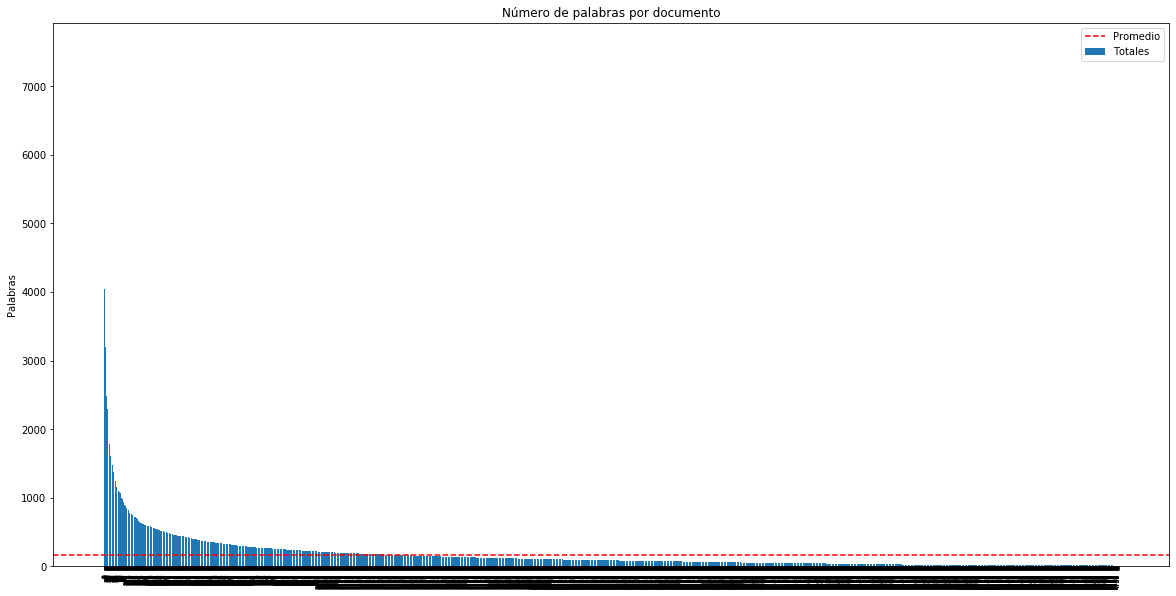

In [130]:
wi.grafica_palabras_porDoc(df)

# **Reducción del tamaño de las matrices**

Para reducir la complejidad espacial de nuestro ejercicio, podemos hacer dos cosas:
* 1.- Un muestreo aleatorio de documentos, lo que nos ayudaría a reducir el vocabulario. 
* 2.- Un recorte en el número de documentos por la cantidad de palabras.
Usaremos el segundo.

Obtenemos el vocabulario.
Para ello vamos a usar el método de tokenización de NLTK

In [131]:
textos = df['Texto'].values
textos = " ".join(textos)
vocabulario = set(word_tokenize(textos))
print(len(vocabulario),'palabras únicas (tipos)')

103133 palabras únicas (tipos)


Filtramos algunos documentos

In [12]:
df=df[(df.Total < 200) & (df.Total > 50)]
print(len(df))
df.index = range(len(df.index))
df.head()

2006


,doc_id,Texto,clase,Palabras,Total,Conteos
0,1896200,jardín botánico villa thuret francés jardin bo...,0,"[jardín, botánico, villa, thuret, francés, jar...",199,"{'jardín': 6, 'botánico': 3, 'villa': 5, 'thur..."
1,1881014,introducción cinco tesoro isla five treasure i...,0,"[introducción, cinco, tesoro, isla, five, trea...",199,"{'introducción': 1, 'cinco': 4, 'tesoro': 5, '..."
2,1885576,estudios sonosfera estudios grabación fundados...,0,"[estudios, sonosfera, estudios, grabación, fun...",199,"{'estudios': 5, 'sonosfera': 3, 'grabación': 4..."
3,1897742,coso ciudad altoaragonesa huesca larga calle r...,0,"[coso, ciudad, altoaragonesa, huesca, larga, c...",199,"{'coso': 11, 'ciudad': 1, 'altoaragonesa': 1, ..."
4,1889776,miss venezuela celebró caraballeda vargas vene...,0,"[miss, venezuela, celebró, caraballeda, vargas...",199,"{'miss': 29, 'venezuela': 8, 'celebró': 1, 'ca..."


Promedio de palabras por documento en el corpus: 110.1136590229312
[199 199 199 199 199 199 199 199 198 198]


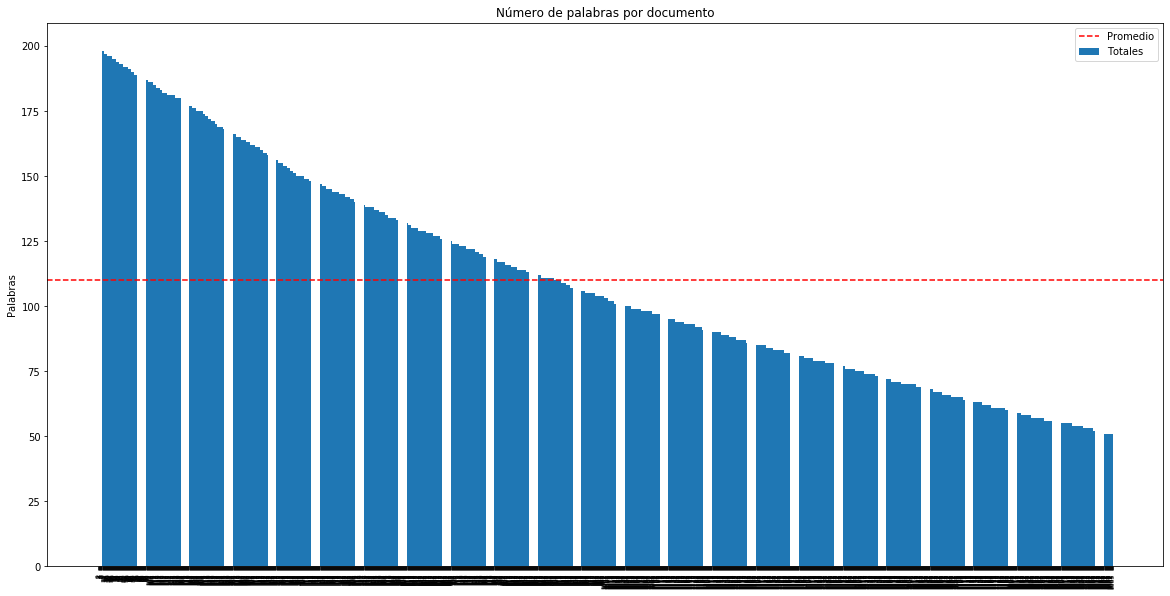

In [133]:
wi.grafica_palabras_porDoc(df)

### Guardamos el data frame

Para ello, vamos a usar [pickle](https://docs.python.org/2/library/pickle.html), que forma parte de las [funcionalidades de I/O](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) de Pandas.

Pickle permite serializar y deserializar una estructura de datos Python. "_Pickling_" es el proceso mediante el cual una jerarquía de objetos de Python se convierte en una secuencia de bytes, y "_Depickling_" es la operación inversa, mediante la cual una secuencia de bytes se convierte nuevamente en una jerarquía de objetos.

In [25]:
df.to_pickle('Data/data_frame_4K.pkl')

___

# Leemos un Data Frame previamente almacenado

In [26]:
df=pd.read_pickle('Data/data_frame_4K.pkl')
df.index = range(len(df.index))
print(df.shape)
df.head()

(2006, 6)


,doc_id,Texto,clase,Palabras,Total,Conteos
0,1896200,jardín botánico villa thuret francés jardin bo...,0,"[jardín, botánico, villa, thuret, francés, jar...",199,"{'jardín': 6, 'botánico': 3, 'villa': 5, 'thur..."
1,1881014,introducción cinco tesoro isla five treasure i...,0,"[introducción, cinco, tesoro, isla, five, trea...",199,"{'introducción': 1, 'cinco': 4, 'tesoro': 5, '..."
2,1885576,estudios sonosfera estudios grabación fundados...,0,"[estudios, sonosfera, estudios, grabación, fun...",199,"{'estudios': 5, 'sonosfera': 3, 'grabación': 4..."
3,1897742,coso ciudad altoaragonesa huesca larga calle r...,0,"[coso, ciudad, altoaragonesa, huesca, larga, c...",199,"{'coso': 11, 'ciudad': 1, 'altoaragonesa': 1, ..."
4,1889776,miss venezuela celebró caraballeda vargas vene...,0,"[miss, venezuela, celebró, caraballeda, vargas...",199,"{'miss': 29, 'venezuela': 8, 'celebró': 1, 'ca..."


# **BoW**

* Para obtener la Bolsa de Palabras, vamos a utilizar la columna de Conteos con los conteos de palabras respectivos por cada documento.

* Esta columna consta de diccionarios que usaremos como entrada para el módulo [DictVectorizer de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html). Este módulo transforma listas de mapeos (dicconarios) de valores de características en vectores. Este transformador convierte las listas de mapeos (objetos similares a dict) de nombres de entidades a valores de entidades, en matrices Numpy o matrices scipy.sparse para usar con estimadores de scikit-learn. Cuando los valores de las características son cadenas (strings), este transformador realizará una codificación binaria del tipo One-Hot (también conocido como uno-de-K): se construye una característica con valor booleano para cada uno de los posibles valores de string que la característica puede asumir.

* Primero, vamos a definir nuestra función BOW. Esta función recibe una lista de diccionarios y regresa una matriz $X$ de documentos y un diccionario $v$ con el vocabulario asociado a un entero. 

**Cada fila de $X$ es un documento y cada columna representa una palabra del vocabulario.**

<img src="../img/BoW_M.png" width="300"/>

In [13]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter, OrderedDict

def bow_(docs):
    v = DictVectorizer(sparse=False)
    X = v.fit_transform(docs)
    return X,v

In [14]:
docs = df.Conteos.tolist()
X,vocab_ = bow_(docs)
print(X.shape)

(2006, 46295)


In [15]:
print('X:')
print(X[:2])
print('La primer fila de la matriz X suma {} conteos que coincide con el primer documento.'.format(int(X[0].sum())))
print('La segunda fila de la matriz X suma {} conteos que coincide con el segundo documento.'.format(int(X[1].sum())))

X:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
La primer fila de la matriz X suma 199 conteos que coincide con el primer documento.
La segunda fila de la matriz X suma 199 conteos que coincide con el segundo documento.


# **Métodos de reducción de dimensionalidad y codificación latente**

El análisis de componentes principales (PCA) y la descomposición de valores singulares (SVD) son enfoques de reducción de dimensionalidad comúnmente utilizados en el análisis de datos exploratorios y el aprendizaje automático. 

Ambos son métodos clásicos de reducción de dimensionalidad lineal que intentan encontrar combinaciones lineales de características en la matriz de datos de alta dimensión original para construir una representación significativa del conjunto de datos.

PCA tiene como objetivo encontrar ejes ortogonales linealmente no correlacionados, que también se conocen como componentes principales (PC) en el espacio dimensional m (espacio de las características &mdash;_features_) para proyectar los puntos de datos en esas PC. La primera PC captura la mayor variación en los datos.

<img src="../img/PCA.gif" width="375" height="375"/>

Las representaciones resultantes de PCA y SVD son similares para algunos datos, ya que PCA y SVD están estrechamente relacionados. Si tenemos:

<img src="../img/PCA_SVD-1.png" width="75"/> 

donde, $\mathbf{x}_i=[x_1,x_2,\cdots,x_d]$ son muestras observadas de datos $d-$dimensionales, $d\in \mathbb{N}$.

Los $k$ _ejes principales_ $\mathbf{w}_j$, $j \in \{1,\cdots,k\}$, son aquellos ejes ortonormales sobre los cuales la varianza de la proyección es máxima. 

**¿Por qué la varianza?**:
Se puede considerar cualquier conjunto de observaciones como una señal contaminada con ruido. Lo deseable es maximizar la razón señal-a-ruido (SNR):
<center>
$SNR=\frac{\sigma^2_{senal}}{\sigma^2_{ruido}}$
</center>

Esto es equivalente a encontrar una transformación que permita proyectar las observaciones sobre ejes que maximicen la varianza de los datos y minimicen la varianza del ruido.

Visto de otra forma, se desea encontrar ejes de proyección de los datos en donde haya la **menor** redundancia (i.e. correlación) posible; es decir, ejes en donde la varianza de la señal sea máxima y su correlación con respecto a otros ejes ("ruido") sea mínima:

<img src="../img/COV.png" width="350"/>

Se puede demostrar que estos ejes $\mathbf{w}_j$ están dados por los $k$ vectores propios dominantes (i.e. los asociados con los valores propios más grandes) de la matriz de covarianza de las muestras
<center>
$\mathbf{S}=\sum_{i}(\mathbf{x}_i-\bar{\mathbf{x}})(\mathbf{x}_i-\bar{\mathbf{x}})^{^\textrm{T}}/N$ 
</center>
donde $\bar{\mathbf{x}}$ es la media de las muestras, de tal forma que
<center>
$\mathbf{S}\mathbf{w}_j=\lambda_j\mathbf{w}_j$. 
</center>

Escribiendo $\mathbf{P}=\mathbf{W}^{^\textrm{T}}$, las $k$ componentes principales del vector observado $\mathbf{x}_n$ están dadas por el vector: 
<center>
$\mathbf{p}_n=\mathbf{P}\,(\mathbf{x}_n-\bar{\mathbf{x}})$. 
</center>

De esta forma, las filas de $\mathbf{P}$ son _las componentes principales_ de $\mathbf{X}$ y constituyen una nueva base sobre la que se pueden proyectar los vectores $\mathbf{x}_n$:
<center>
$\mathbf{Y}=\mathbf{P}\,\mathbf{X}$. 
</center>




<img src="../img/PCA_3.png" width="400"/>
<em><center>Proyección de la matriz original en el espacio de componentes principales (Tharwat, 2016)</em></center>

# **PCA**

In [16]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='auto')

Y_pca = pca.fit_transform(X)

In [17]:
print(Y_pca.shape)
print(Y_pca[:2])

(2006, 2006)
[[-3.97046224e-01  6.58263561e-02 -2.08655710e-01 ...  2.56124315e-15
  -5.51853432e-19 -3.89108885e-46]
 [-6.10801431e-01  1.86606851e-01 -5.07533396e-01 ...  2.56124315e-15
  -5.51853432e-19  2.54948646e-46]]


In [32]:
np.save('Data/Y_pca.npy', Y_pca)

In [33]:
Y_pca = np.load('Data/Y_pca.npy')

In [18]:
ypca = pd.DataFrame(Y_pca)
ypca['doc_id']=df['doc_id'].copy()

cols = ypca.columns.tolist()
cols = cols[-1:] + cols[:-1]
ypca=ypca[cols]

print(ypca.shape)
ypca.head()

(2006, 2007)


,doc_id,0,1,2,3,4,5,6,7,8,...,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005
0,1896200,-0.397046,0.065826,-0.208656,-0.326621,-0.222124,-0.537293,-0.501059,-1.110444,0.430676,...,0.000923,0.001119,0.000234,0.001011,0.001428,-0.000067,0.000159,2.561243e-15,-5.518534e-19,-3.891089e-46
1,1881014,-0.610801,0.186607,-0.507533,-3.363084,-1.509550,8.651002,0.755407,-1.668928,1.293250,...,-0.001174,0.001489,0.000088,-0.000461,-0.001868,0.000054,-0.000296,2.561243e-15,-5.518534e-19,2.549486e-46
2,1885576,0.257185,-0.862755,-0.679346,-0.217889,1.420259,0.155632,0.593849,0.178755,-0.496738,...,-0.006366,-0.002978,-0.001313,0.001137,-0.000644,0.000031,-0.000429,2.561243e-15,-5.518534e-19,-3.975675e-45
3,1897742,-2.355385,0.362323,2.668149,-4.339048,-3.588703,-1.827023,3.979391,2.202862,-1.521509,...,0.001553,0.007664,0.005811,-0.000630,0.001240,-0.000037,0.001502,2.561243e-15,-5.518534e-19,4.241004e-45
4,1889776,-0.296757,-0.402908,-0.829722,-0.057294,0.305550,0.357160,0.613522,-2.040624,-1.190819,...,0.000526,-0.000935,-0.000713,0.000228,0.000545,0.000068,0.000043,2.561243e-15,-5.518534e-19,2.918487e-45


In [19]:
"""Proporción de la varianza por componente"""
pca_vr=pca.explained_variance_ratio_
print(pca_vr[:10])

[0.01013527 0.00906409 0.00779159 0.00668381 0.0061231  0.00558941
 0.0055032  0.00503977 0.00479507 0.00443493]


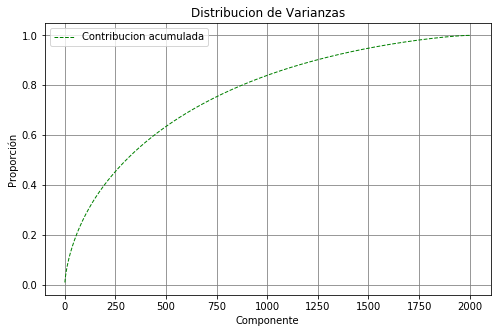

In [20]:
D=pca_vr[:]

"""Varianza acumulada"""
d=np.cumsum(D)

"""Areas de Graficacion y visualizacion de los datos"""
fig,ax = plt.subplots(figsize=(8,5))

pasos=range(len(D))
datos=np.array(list(map(lambda x,y:[x,y],pasos,d)))
ax.plot(datos[:,0],datos[:,1],
        ls='--',
        color='green',
        linewidth=1,
        label='Contribucion acumulada')
plt.title('Distribucion de Varianzas')
plt.xlabel('Componente')
plt.ylabel('Proporción')
plt.grid(True)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(which='major', color='gray', linestyle='-')
ax.grid(which='minor', color='grey', linestyle='--')
ax.legend()
plt.show()

# **Ejercicio**

Queremos saber que tan bien podemos modelar documentos utilizando estas técnicas de reducción de dimensionalidad.

Observa la distribución de los componentes principales de la matriz BoW, calculados por PCA y por LSI. 

Elige un número $q$ de componentes principales (que llamaremos _representativos_) para PCA y compara la calidad de los documentos más cercanos (semejantes) a los documentos de análisis mostrados aquí abajo.

## Análisis usando PCA

### Modelación de documentos utilizando componentes principales

In [21]:
def get_representativos(df,numero=100):
    cols = [col for col in df.columns[:numero+1]]
    rep = df.loc[:, cols]
    return rep

In [58]:
q=2  #elige un numero q de componentes principales
df_pca=get_representativos(ypca,q)
print(df_pca.shape)
df_pca.head()

(2006, 3)


,doc_id,0,1
0,1896200,-0.397046,0.065826
1,1881014,-0.610801,0.186607
2,1885576,0.257185,-0.862755
3,1897742,-2.355385,0.362323
4,1889776,-0.296757,-0.402908


### &#9998; Dibuja los puntos (documentos)

In [ ]:
fig,ax=plt.subplots()
""" TU CODIGO AQUI """

"""--------------"""
plt.show()

### Documentos de análisis

In [60]:
docus = df.head().copy()
docus.drop(columns=['Total','Conteos','Palabras','clase'],inplace=True)  
docus.index=range(len(docus.index))

docus

,doc_id,Texto
0,1896200,jardín botánico villa thuret francés jardin bo...
1,1881014,introducción cinco tesoro isla five treasure i...
2,1885576,estudios sonosfera estudios grabación fundados...
3,1897742,coso ciudad altoaragonesa huesca larga calle r...
4,1889776,miss venezuela celebró caraballeda vargas vene...


### Calculamos el vecino más cercano a cada uno de los documentos de análisis

In [61]:
def dist_vecinos(id_docu,df):
    dist=[]
    candidato = df[df['doc_id']==id_docu]
    candidato = candidato.iloc[:,1].values[0]
    fila=df.index[df['doc_id'] == id_docu].tolist()
    pts=df.drop(df.index[fila])
    id_=pts.doc_id.values
    pts=pts.iloc[:,1].values

    for i in range(len(pts)):
        d = np.sqrt(np.sum(np.square(candidato-pts[i])))
        dist.append((id_docu,id_[i],d))
    dist=sorted(dist,key=lambda x: x[2])
    return dist

def k_vecinos_mas_cercanos(docus,df,k=1):
    l=docus.doc_id.values
    vec=OrderedDict()
    for id_ in l:
        d=dist_vecinos(id_,df)
        for i in range(k):
            if i==0:
                vec[id_]=[[d[i][1],d[i][2]]]
            else:
                vec[id_].append([d[i][1],d[i][2]])
    return vec

In [62]:
k=1
vecinos_pca=k_vecinos_mas_cercanos(docus,df_pca,k)

### Por cada documento de análisis, podemos ver qué documento es el más semejante (el vecino más cercano)

In [63]:
doc_names=list(docus.doc_id.values)

nivel=0
vecinos=[]
for d in doc_names:
    vecinos.append(vecinos_pca[d][nivel])
print(vecinos)

[['1885814', 0.0004828216557195564], ['1883605', 0.000507755122934217], ['1895033', 0.0008445378621166344], ['1892929', 0.023499314930265136], ['1896150', 3.702000621252921e-05]]


In [64]:
vecinos=dict(vecinos)
for id_ in vecinos.keys():
    txt=df[df.doc_id==id_].Texto.values
    vecinos[id_]=list(txt)[0]
vecinos=pd.DataFrame(vecinos.items(),columns=['vecino','Texto_vecino'])
vecinos

,vecino,Texto_vecino
0,1885814,mathias stomer amersfoort sicilia pintor holan...
1,1883605,mohamed ould maaouya méderdra agosto político ...
2,1895033,philipp wilhelm wirtgen diciembre septiembre b...
3,1892929,anthony jarrad morrow nacido septiembre charlo...
4,1896150,meiofauna compuesta pequeños animales habitan ...


In [65]:
datos_PCA=pd.concat([docus,vecinos],axis=1)
datos_PCA=datos_PCA.astype({'Texto':str, 'Texto_vecino':str})
datos_PCA

,doc_id,Texto,vecino,Texto_vecino
0,1896200,jardín botánico villa thuret francés jardin bo...,1885814,mathias stomer amersfoort sicilia pintor holan...
1,1881014,introducción cinco tesoro isla five treasure i...,1883605,mohamed ould maaouya méderdra agosto político ...
2,1885576,estudios sonosfera estudios grabación fundados...,1895033,philipp wilhelm wirtgen diciembre septiembre b...
3,1897742,coso ciudad altoaragonesa huesca larga calle r...,1892929,anthony jarrad morrow nacido septiembre charlo...
4,1889776,miss venezuela celebró caraballeda vargas vene...,1896150,meiofauna compuesta pequeños animales habitan ...


### Traemos los textos correspondientes y comparamos

In [67]:
for docu in list(docus.doc_id.values):
    print('\nDocumento: {} Texto de referencia:\n'.format(docu))
    print(datos_PCA[datos_PCA.doc_id==docu].Texto.values[0][:200])
    print('\nTexto más cercano:\n')
    print(datos_PCA[datos_PCA.doc_id==docu].Texto_vecino.values[0][:200])


Documento: 1896200 Texto de referencia:

jardín botánico villa thuret francés jardin botanique villa thuret jardín botánico hectáreas ubicado terrenos villa thuret antibes francia código identificación internacional institución botánica inra

Texto más cercano:

mathias stomer amersfoort sicilia pintor holandés estilo tenebrista nombre escribe formas diversas figura fuentes matthias stomer mathias stom conocen pocos datos seguros vida cree inició pintura abra

Documento: 1881014 Texto de referencia:

introducción cinco tesoro isla five treasure island primer libro serie cinco enid blyton editado argumento llegan vacaciones pequeños julian julián dick anne ana repentino viaje negocios padre escocia

Texto más cercano:

mohamed ould maaouya méderdra agosto político mauritania ministro interior descentralización gobierno bajo control militar surgido tras golpe cursó estudios superiores formándose administración públic

Documento: 1885576 Texto de referencia:

estudios sonosfera estudios 

___

# &#9998; TAREA:
* Elige un método de los vistos en el curso y haz un análisis de clusters de la matriz PCA.
* Reporta tus resultados en un documento PDF.